<img src="https://3a2vzv37nkuw3esf6a3u2t7s-wpengine.netdna-ssl.com/webcentral/wp-content/uploads/sites/267/2019/02/horizontaldarkbackground.jpg" width="55%" align="left"> 
<br><br><br><br><br>
<font size=3 color='#08088A'>
<b>CSCI250 Python Computing: Building a Sensor System</b> <br><br>
Capstone final report
</font>
<hr style="height:5px" width="55%" align="left">

# Security System

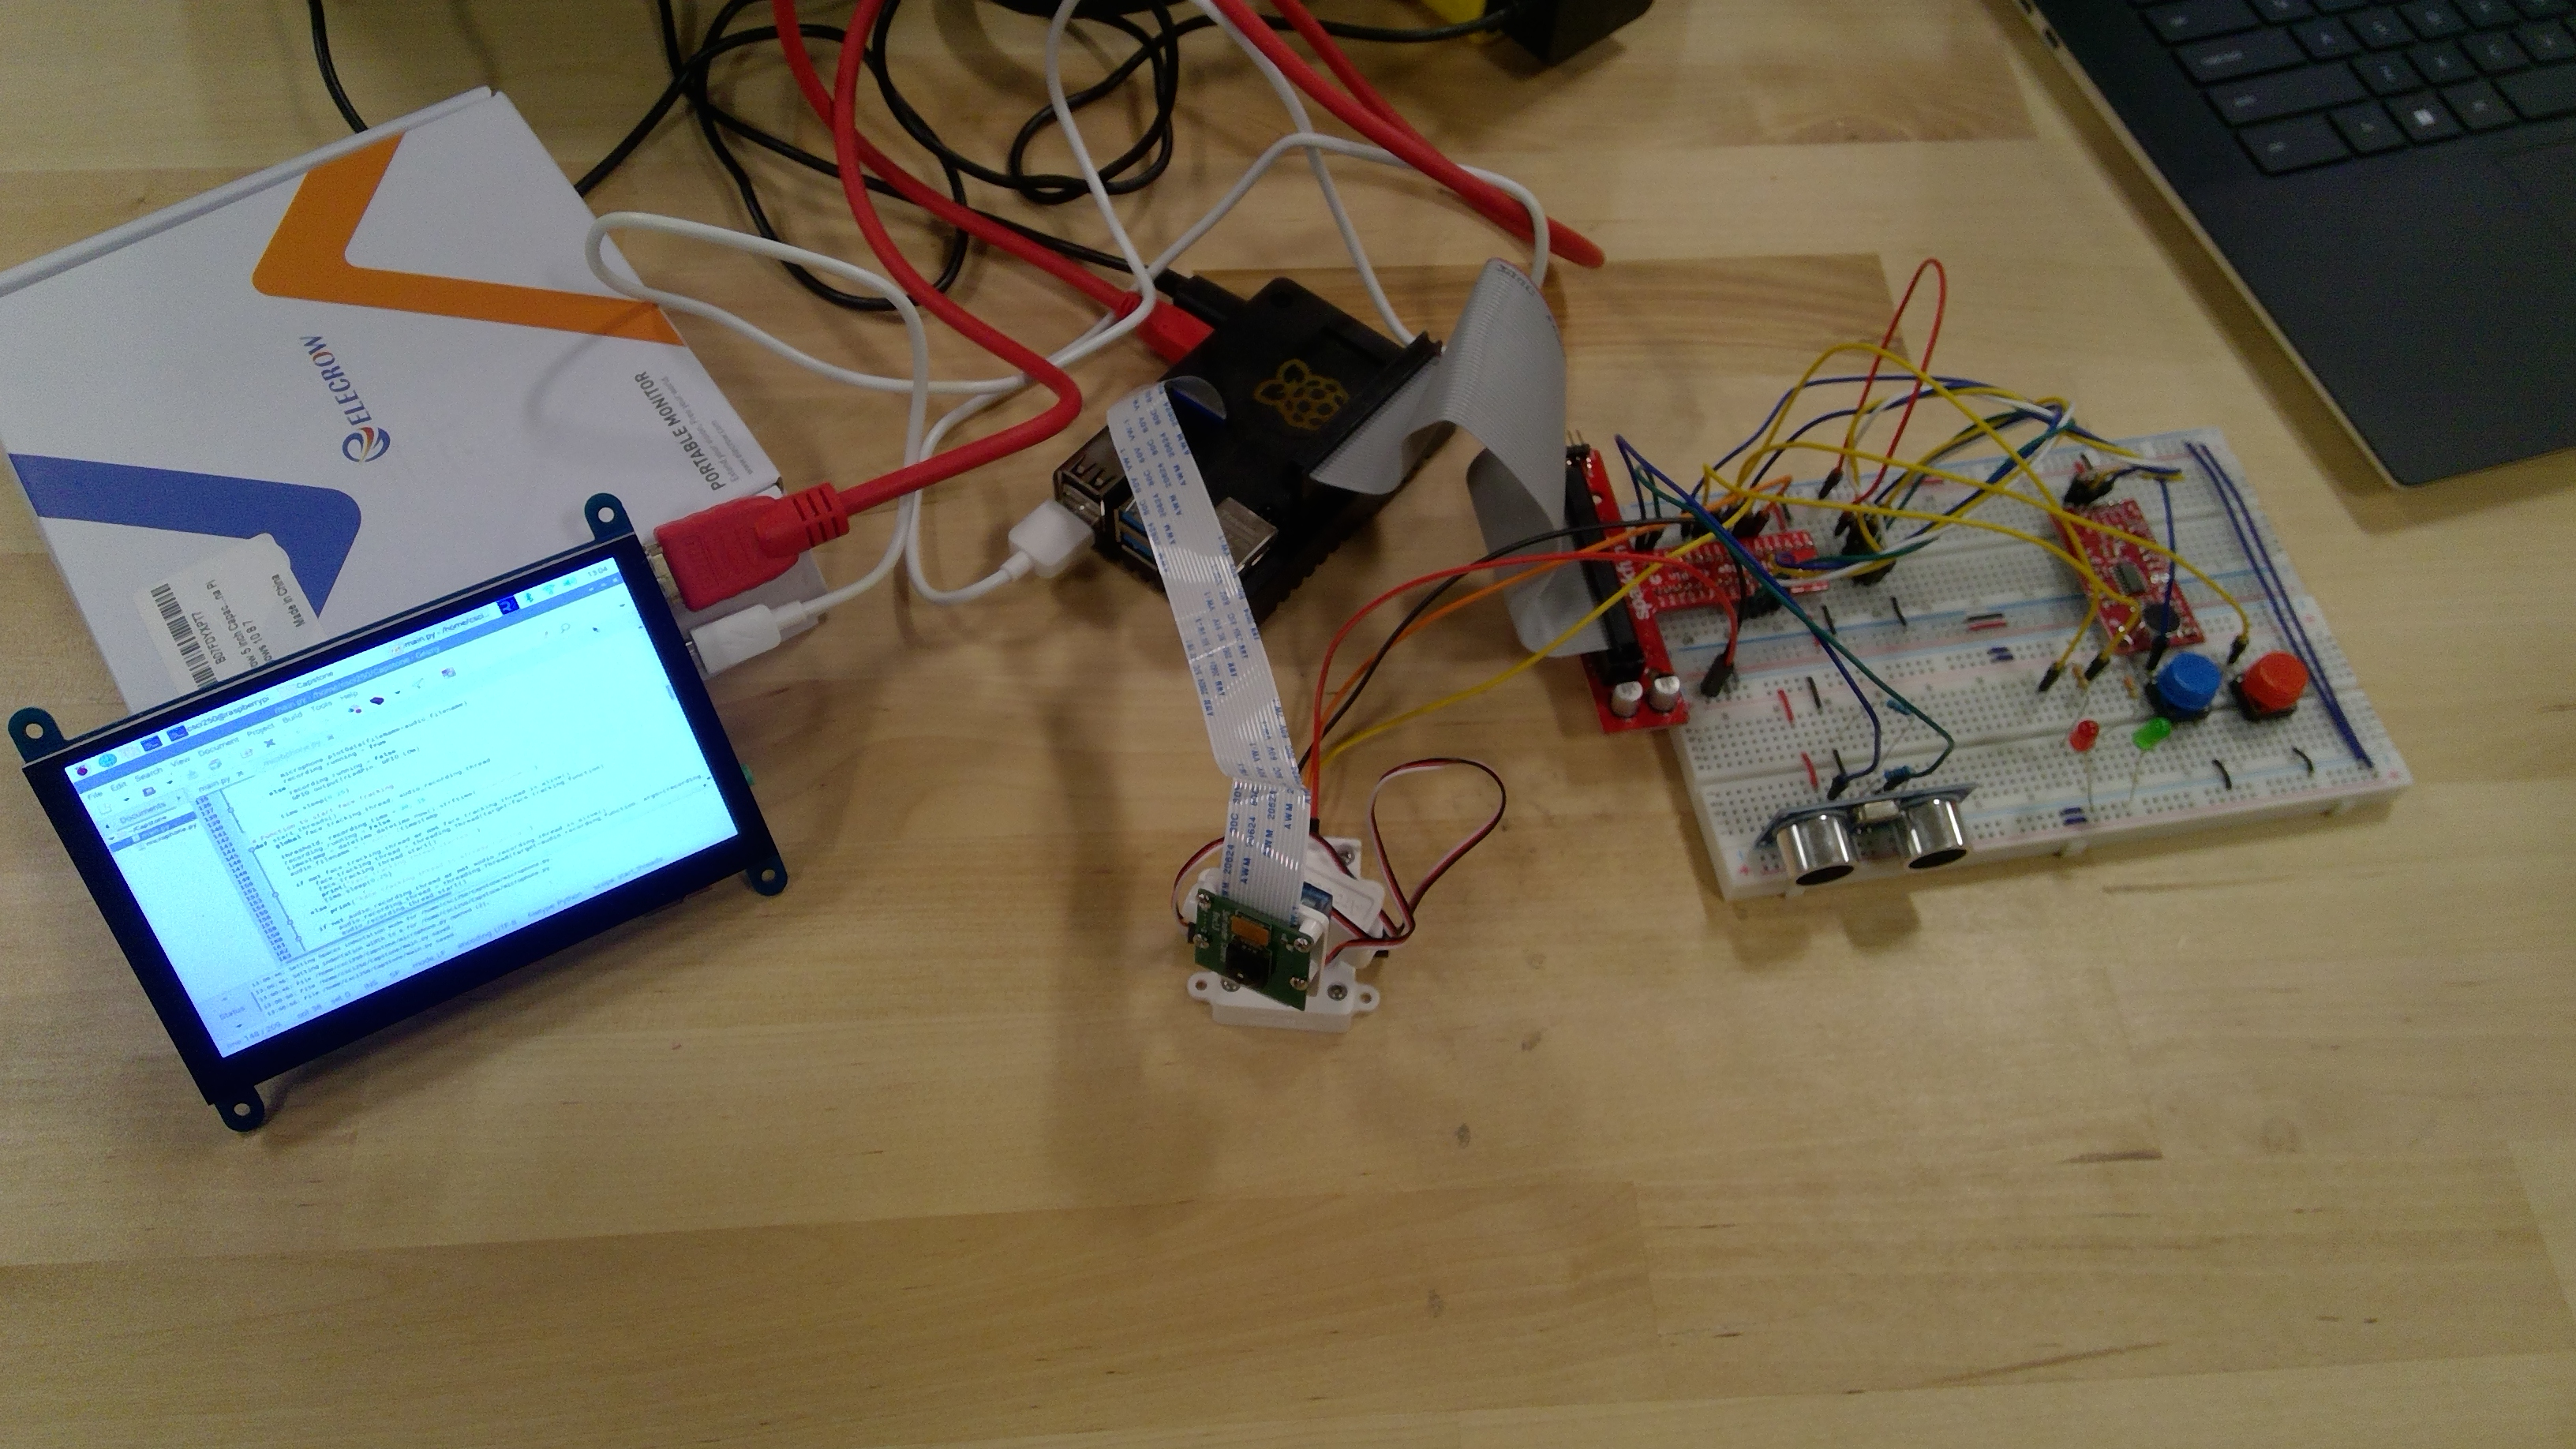

# Group 

List all members and indicate specific project responsibilities:

* Tanner Bearden - Camera tracking 
* Matt Boughey - Button/Led/system I/O control
* Elijah Cook - Distance sensor

# Description

Our project is a security system which measures distance and triggers face tracking when something gets too close. The system records audio after it has been triggered and then processes that data and stores the graphs to a png file.

# Hardware

Ultrasonic distance sensor, used for triggering the audio recording system and recording distances. <br>
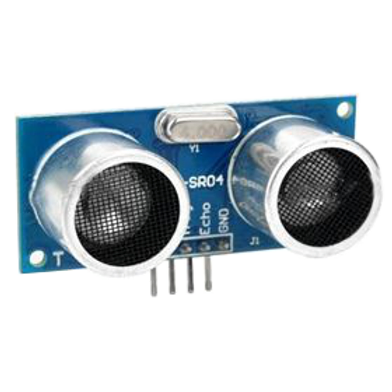 <br>
Microphone: used for recording sound after the system has been triggered. <br>
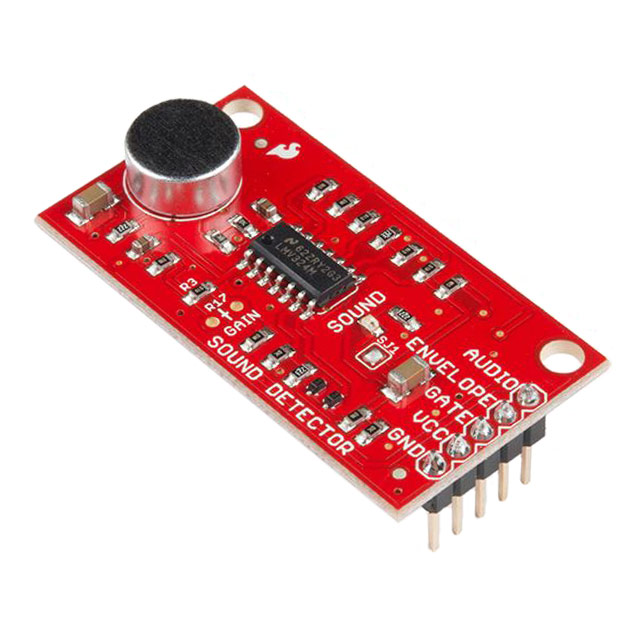 <br>
Led's: used for displaying recording and power statuses. <br>

Button: used to activate and deactivate the sytem. <br>

ADC: used for reading in analog signals from microphone. <br>

5 inch display: used for monitoring video output on the device. This alows for us to run our face tracking software. <br>
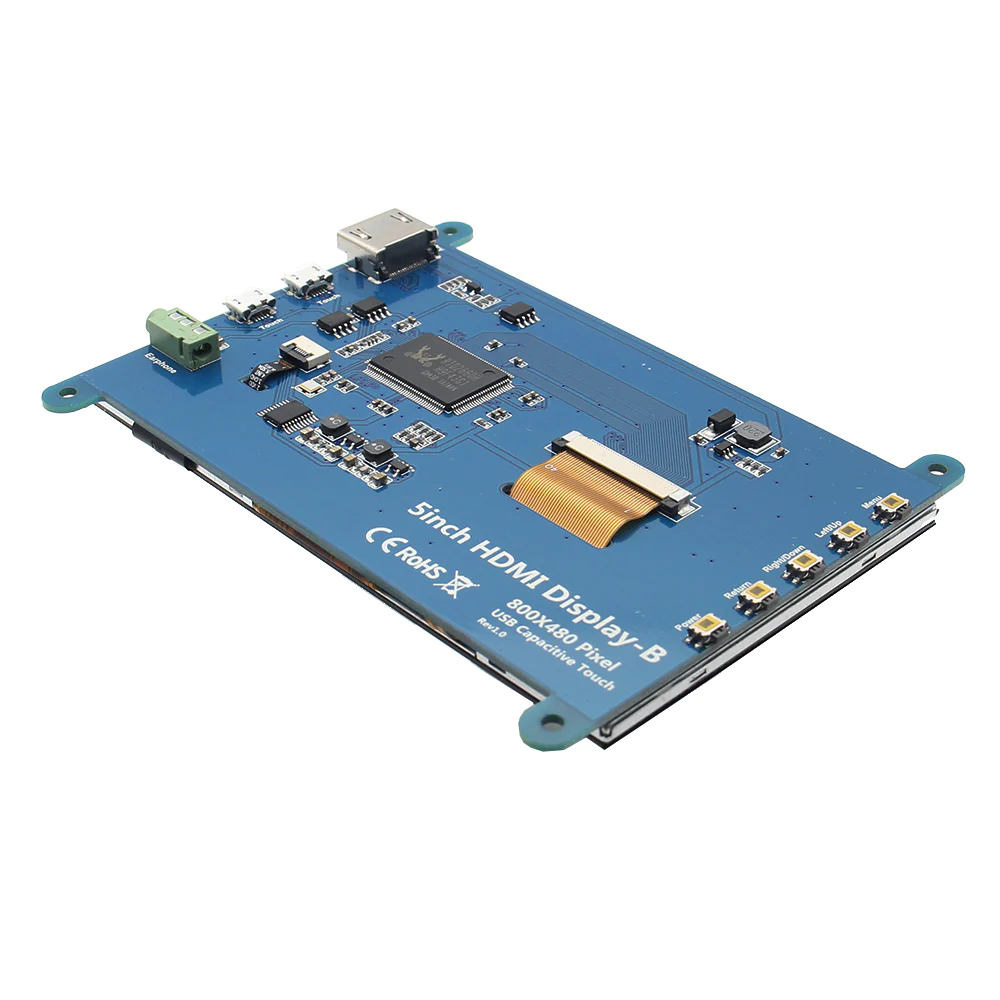

# Operation

Describe how to use or operate your project. If it's a game, describe how to play.

One button activates and deactivates the security system. While the security system is active it takes distance measurements at regular intervals. When something comes within a certain distance, face tracking activates on the camera, and a red led turns on to indicate that audio and video recording is in progress. The system is activated with the red button. It runs on two main threads, one for video and one for audio. This allows for both to run in the background along side each other.

# Data

As stated in the capstone guidelines notebook, your project must have 4 data components:

1. **Collect** data
2. **Process** data
3. **Display** data
4. **Interpret** data

Include a description of the data you collected, what processing you did, graphs/plots/visuals created by your code, and your interpretation/analysis of the data. 

There is no need to include raw data unless it helps your explanation.

We collect the audio data from the microphone and use the gate information to zero out quiet periods, we then plot this data. Using the mic data the user can observe spikes in audio that may indicate a break in has occurred.

# Wiring

Include a a description or schematic of how all hardware elements are connected to your RPi. Be specific about what is connected where. There are several websites that allow you to create circuit schematics for free, such as [this one](https://www.circuit-diagram.org/editor/).

A ribbon cable is used for the pi camera. The servos which the camera is mounted on are connected to SDA, SCl, 5V, and ground. The distance sensor is connected to ground and 5V, the trigger pin is connected to GPIO 18 and the echo pin is connected to GPIO 19. An ADC is connected according to the below diagram. A microphone is connected to 3V and ground. The envelope and audio are connected to ADC channels 0 and 1 respectively. Gate from the microphone is connected to gpio 23. Two buttons are connected in the pull-up configuration each is connected to ground and the start button is connected to GPIO 27 while the end button is connected to GPIO 22. A green and red led are connected to GPIO pins 24 and 25 respectively each in series with a 330 ohm resistor. The 5 inch display is connected to the pi via a HDMI to micro-HDMI cable and a micro usb cable which provides power and touch screen functionality.

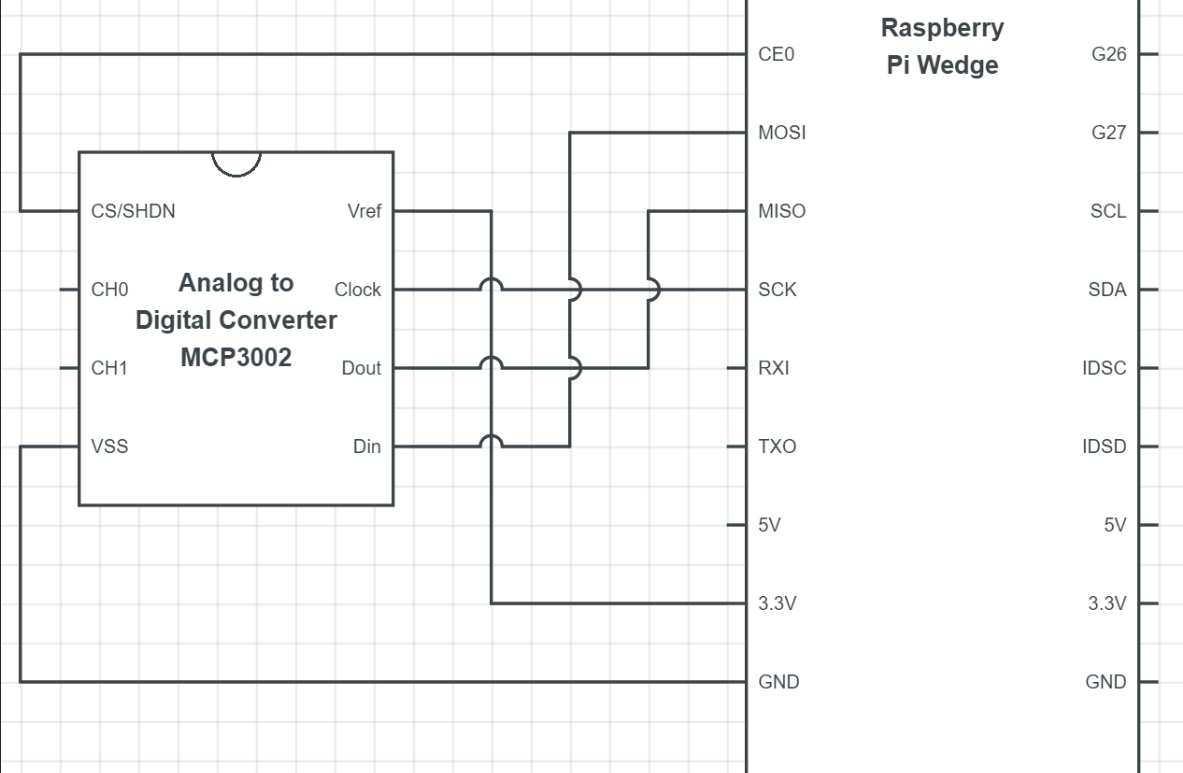

# Code

In [ ]:

# microphone.py
import time
import numpy as np
import adcUtil as adc
import RPi.GPIO as GPIO
import matplotlib
matplotlib.use('Agg')           # allow matplotlib to not plot data but rather save to a file
import matplotlib.pyplot as plt
import pandas as pd



class Microphone:
    def __init__(self, mic_gatePin):
        self.mic_vin_flex = 3.3
        self.mic_res = 10.0 # kOhm ( may change depending on resistor used )
        self.mic_gatePin = mic_gatePin
        GPIO.setup(mic_gatePin, GPIO.IN)

    
    def saveTrack(self, fileName, time_arr, audio_arr, env_arr, gate_arr):
        np.savez(fileName, time_arr=time_arr, audio_arr=audio_arr, env_arr=env_arr, gate_arr=gate_arr) # save arrays to file

    def plotData(self, fileName):
        
        graphs = plt.figure(figsize=[20,5]) #set figure size
        
        print("Saving and plotting data")
        
         #load the archived files
        with np.load(fileName) as arrays:
            time = arrays['time_arr']
            audio = arrays['audio_arr']
            envelope = arrays['env_arr']
            gate = arrays['gate_arr']
        audioAndGate = np.multiply(audio, gate) #zero out quiet periods
        audioNoBias = audio - np.mean(audio) #subtract out noise
        audioGateNoBias = audioNoBias * gate #do both

        #setup graph 1
        graph1 = graphs.add_subplot(1, 3, 1)
        graphs.subplots_adjust(wspace=.2)
        graph1.plot(time, audio, 'b', label="Raw Audio")
        graph1.plot(time, envelope, 'r', label="Raw Envelope")
        graph1.legend()
        graph1.set_xlabel('Time')
        graph1.set_ylabel('Mic stuff')
        graph1.set_title('Raw Data')

       

        #setup for the second graph
        graph2 = graphs.add_subplot(1, 3, 2)
        graph2.plot(time, audioAndGate, 'b', label="Gate Modified Audio")
        graph2.plot(time, audioNoBias, 'r', label="Bias Subtracted Audio")
        graph2.plot(time, audioGateNoBias, 'purple', label="Gate Modified & Bias Subtracted")
        graph2.legend()
        graph2.set_xlabel("Time")
        graph2.set_ylabel("Noise Level")
        graph2.set_title("Modified Audio signal")

        #get rolling
        newEnv = pd.Series(envelope)
        ROLL_WINDOW = len(time) // 10
        rollAverage = newEnv.rolling(ROLL_WINDOW).mean()
        rollStd = newEnv.rolling(ROLL_WINDOW).std()

        #setup for the third graph
        graph3 = graphs.add_subplot(1, 3, 3)
        graph3.plot(time, newEnv, 'r', label="Raw data")
        graph3.plot(time, rollAverage, 'b', label="Rolling Average")
        graph3.fill_between(time, rollAverage - rollStd, rollAverage + rollStd, color="pink", label= "Mean $\pm \sigma$")
        graph3.legend()
        graph3.set_xlabel("Time")
        graph3.set_ylabel("Noise Level")
        graph3.set_title("Envelope Signal")
        
        graphs.savefig(fileName + '.png')
        print("Done plotting")

    def recordAudio(self, mic_audioChannel, mic_envelopeChannel, mic_device, recordTime, fileName):
        
        while True:
            
            # read resistane
            print("RECORDING AUDIO")

            # grab current time
            start_time = time.time()

            # init arrays
            time_arr  = np.empty(0)
            env_arr   = np.empty(0)
            gate_arr  = np.empty(0)
            audio_arr = np.empty(0)


            while (time.time() - start_time <= recordTime): # record for 15 seconds
                # grab mic channels
                gateState = GPIO.input(self.mic_gatePin)
                Vaudio = adc.readADC(channel=mic_audioChannel, device=mic_device)
                Venvelope = adc.readADC(channel=mic_envelopeChannel, device=mic_device)

                # append values
                time_arr = np.append(time_arr, start_time - time.time())
                gate_arr = np.append(gate_arr, gateState)
                audio_arr = np.append(audio_arr, Vaudio)
                env_arr = np.append(env_arr, Venvelope)
                
                print(time.time() - start_time)
                
            print("RECORDING OVER")
            break
        
        self.saveTrack(fileName, time_arr, audio_arr, env_arr, gate_arr)



In [ ]:
# main.py
import RPi.GPIO as GPIO
import numpy as np
import time
import datetime
import cv2
import threading
from microphone import Microphone
from adafruit_servokit import ServoKit

# SERVO INIT
kit = ServoKit(channels=16)
x_position, y_position = 90, 115
kit.servo[0].angle, kit.servo[1].angle = y_position, x_position # set servos to default position

# GPIO INIT
GPIO.setmode(GPIO.BCM)
buttonPin, buttonPin2 = 27, 23
microphonePin = 26
rLedPin, gLedPin = 25, 24
ultraEchoPin, ultraTrigPin = 19, 18
GPIO.setup([rLedPin, gLedPin, ultraTrigPin], GPIO.OUT)
GPIO.setup([microphonePin, ultraEchoPin], GPIO.IN)
time.sleep(2)
GPIO.setup(buttonPin, GPIO.IN, pull_up_down=GPIO.PUD_UP)
GPIO.setup(buttonPin2, GPIO.IN, pull_up_down=GPIO.PUD_UP)

GPIO.output(gLedPin, GPIO.LOW)
GPIO.output(rLedPin, GPIO.LOW)

# MICROPHONE INIT
micAudioChannel, micEnvChannel = 0, 1
micDevice = 0
microphone = Microphone(microphonePin)

In [ ]:

# function to get distance
def get_distance():
    GPIO.output(ultraTrigPin, True)
    time.sleep(0.00001)
    GPIO.output(ultraTrigPin, False)
    
    pulse_start = pulse_end = time.time()
    while (GPIO.input(ultraEchoPin) ==0):
           pulse_start = time.time()
    
    while (GPIO.input(ultraEchoPin) ==1):
           pulse_end = time.time()
    #flags print(f"pulse start {pulse_start}")
    #flags print(f"pulse end {pulse_end}")
    pulse_duration = pulse_end - pulse_start
    
    distance = pulse_duration * 17150
    distance = round(distance, 2)
    return distance

# Function for face tracking
def face_tracking_function():
    global x_position, y_position

    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FPS, 60)  # Adjust the frame rate as needed
    _, frame = cap.read()
    rows, cols, _ = frame.shape
    xcenter, ycenter = x_medium, y_medium = int(cols / 2), int(rows / 2)

    # Face detection algorithm. Can be changed to detect other things as well
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    while True: 
        GPIO.output(gLedPin, GPIO.HIGH)
        _, frame = cap.read()

        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = faceCascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            x_medium, y_medium = int((x + x + w) / 2), int((y + y + h) / 2)
            
            cv2.circle(frame, (x_medium, y_medium), 5, (255, 0, 0), -1)
            
            # Adjust servo position based on face position
            if x_medium < xcenter - 45:
                x_position -= 2
            elif x_medium > xcenter + 45:
                x_position += 2
            if y_medium < ycenter - 45:
                y_position += 2
            elif y_medium > ycenter + 45:
                y_position -= 2
                
            break

        

        x_position = max(30, min(150, x_position))
        y_position = max(30, min(150, y_position))

        kit.servo[0].angle, kit.servo[1].angle = y_position, x_position

        
        
        cv2.circle(frame, (xcenter, ycenter), 90, (0, 255, 0), 1)
        
        # put x,y pos on screen
        cv2.putText(frame, f"X-POS: {x_position}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Y-POS: {y_position}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        
        
        cv2.imshow("Face Tracking", frame)
        
        

        if cv2.waitKey(1) & 0xFF == ord('q') or GPIO.input(buttonPin) == 0:
            time.sleep(0.1)
            break

    cap.release()
    cv2.destroyAllWindows()

    


# Function for audio recording
def audio_recording_function(recordTime, audio_filename, threshold, recording_running):

    while True:
        distance = get_distance()
        print(distance)
        if get_distance() < threshold and not recording_running:
            GPIO.output(rLedPin, GPIO.HIGH)
            microphone.recordAudio(micAudioChannel, micEnvChannel, micDevice, recordTime, audio_filename)

            microphone.plotData(fileName=audio_filename)
            recording_running = True
        else:
            recording_running = False
            GPIO.output(rLedPin, GPIO.LOW)
            
        time.sleep(0.25)

# Function to start face tracking
def start_threads():
    global face_tracking_thread, audio_recording_thread

    threshold, recording_time = 30, 15
    recording_running = False
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    audio_filename = f'audio_{timestamp}.npz'

    if not face_tracking_thread or not face_tracking_thread.is_alive():
        face_tracking_thread = threading.Thread(target=face_tracking_function)
        face_tracking_thread.start()
        print("Face tracking thread started!")
        time.sleep(0.25)
    else:
        print("Face tracking thread is already running!")

    if not audio_recording_thread or not audio_recording_thread.is_alive():
        audio_recording_thread = threading.Thread(target=audio_recording_function, args=(recording_time, audio_filename, threshold, recording_running))
        audio_recording_thread.start()
        print("Audio recording thread started!")
        time.sleep(0.25)
    else:
        print("Audio recording thread is already running!")

In [ ]:

# Main loop
try:
    program_running = False

    face_tracking_thread = None
    audio_recording_thread = None

    

    print("PI Ready in...")
    
    for i in range (5, 0, -1):
        print(f"{i}...")
        time.sleep(1)

    print("Ready to Run!")

    while True:
        if GPIO.input(buttonPin) == 0 and not program_running:
            GPIO.output(gLedPin, GPIO.HIGH)
            program_running = True
            start_threads()
        elif GPIO.input(buttonPin) == 0 and program_running:
            break


        program_running = False

except (KeyboardInterrupt, SystemExit):
    print("Program terminated by user ")

finally:
    if face_tracking_thread and face_tracking_thread.is_alive():
        face_tracking_thread.join()
    print("Cleaning up GPIO.")
    
    GPIO.cleanup()

# Credits

Include references to all code you used in your project. If it's a library, provide name, version and download link.

All libraries use most recent versions.

Libraries used: time, numpy, RPi.GPIO, matplotlib, pandas, threading, cv2, datetime, adafruit_servokit

They can all be installed using sudo apt-get install 'name' or pip3 install 'name'
